# Aspen Colorado - Environmental Data 

## Data Import Cleaning and Exploration

Five datasets containing environmental features were combined to develop statistical models related to drought prediction. Weather data was collected from the NOAA website and ground water level and stream flow data was collected from the USGS website, specific URLs are given within the blocks of code and listed in the data references section. The predictors consisted of a weather dataset, a soil moisture and temperature dataset, a groundwater dataset and a streamflow dataset. The target variable was a drought severity dataset. All data were inspected for missing and inconsistent values. Missing values were removed from the datasets. Columns of features that were not necessary were dropped. Individual data features were plotted as time series plots and visually inspected for outliers. Only one outlier was detected in the maximum temperature data and that point was removed. Groundwater and streamflow data were in feet and cubic feet per second respectively. These were converted to centimeters and cubic centimeters per second for consistency as the rest of the data was in metric units. After the data was cleaned the data frames were merged by date creating one dataset, df_aspen. After cleaning all datasets were saved in the Apache Parquet file format to enhance performance and efficiency. 

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis

### Weather Data, Maximum and Minimum Temperature and Preipitation

In [27]:
# Data Download Link: https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00093073/detail

weather_df = pd.read_csv('data/AspenCO.csv')

# Converting DATE_TIME from YYYYMMDDHH to YYYY-MM-DD format
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])

# Extracting date from datetime
weather_df['DATE'] = weather_df['DATE'].dt.date

# Drop unnecessary columns
weather_df = weather_df.drop(weather_df.columns[[0,1,3,4,6,7,10,11,12,13,14,15,16]], axis = 1)

# Drop rows with NaN entries
weather_df = weather_df.dropna()

# Rename columns
weather_df = weather_df.rename(columns = {'DATE': 'date', 'AWND': 'awnd', 'PRCP': 'prcp',
                                         'TMAX': 'tmax', 'TMIN': 'tmin', 'WSF2': 'wsf2'})

print(weather_df.head())
print(weather_df.isna().sum()) # check for NaN entries
print(weather_df.describe())

         date  prcp  tmax  tmin
0  1998-05-21   0.8  20.0   3.3
1  1998-05-22   0.0  16.1  -1.1
2  1998-05-23   0.0  15.6  -1.7
3  1998-05-24   1.0  15.0  -0.6
4  1998-05-25   0.0  21.1  -1.7
date    0
prcp    0
tmax    0
tmin    0
dtype: int64
              prcp         tmax        tmin
count  9727.000000  9727.000000  9727.00000
mean      1.037216    13.653367    -2.20109
std       2.656193    10.733293     8.77779
min       0.000000   -16.100000   -32.20000
25%       0.000000     4.400000    -8.80000
50%       0.000000    14.400000    -1.10000
75%       0.500000    23.300000     5.00000
max      38.100000    50.000000    16.70000


Text(0, 0.5, 'Temperature (C)')

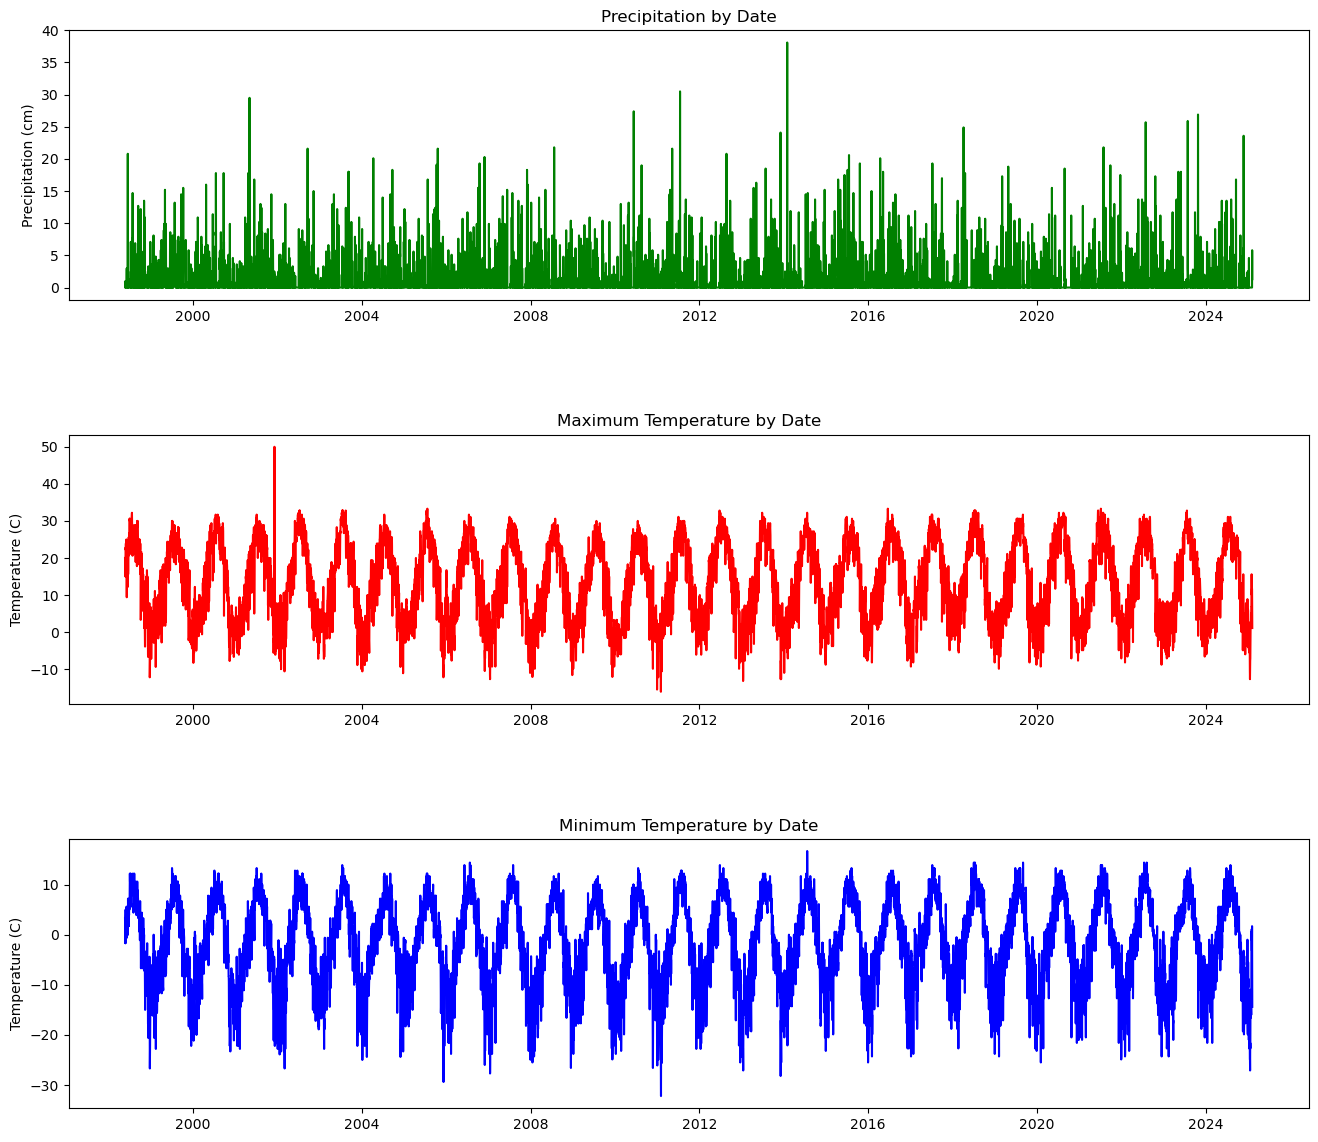

In [21]:
fig, ax = plt.subplots(3,1, figsize = (16, 14))

# adjusting the space between the subplots
plt.subplots_adjust(hspace=0.5)

ax[0].plot(weather_df['date'],weather_df['prcp'], color = 'green')
ax[0].set_title('Precipitation by Date')
ax[0].set_ylabel('Precipitation (cm)')

ax[1].plot(weather_df['date'],weather_df['tmax'], color = 'red')
ax[1].set_title('Maximum Temperature by Date')
ax[1].set_ylabel('Temperature (C)')

ax[2].plot(weather_df['date'],weather_df['tmin'], color = 'blue')
ax[2].set_title('Minimum Temperature by Date')
ax[2].set_ylabel('Temperature (C)')

In [24]:
# Drop outlier in tmax 
max_index = weather_df['tmax'].idxmax()
weather_df = weather_df.drop(max_index)
print(weather_df['tmax'].max())
print(weather_df.isna().sum()) # check for null values

33.3
date    0
prcp    0
tmax    0
tmin    0
dtype: int64


In [27]:
# Save soil data to parquet format 
weather_df.to_parquet('data/weather.parquet', index=False)

### Soil Moisture and Temperature Data

In [33]:
# Data Download Link: https://www.ncei.noaa.gov/data/us-climate-reference-network/access/derived-products/soil/soilanom/
# Data Description: https://www.ncei.noaa.gov/data/us-climate-reference-network/doc/derived-products/soilanom01-readme.txt 

soil_df = pd.read_csv('data/CRNSSM0101-CO_Montrose_11_ENE.csv')
# Selecting Soil Moisture Volumetric Water Content (SMVWC) and Soil Temperature (ST) at 20, 50, and 100 cm depths
soil_df = soil_df[['DATE_TIME', 'SMVWC_20_CM', 'ST_20_CM', 'SMVWC_50_CM', 'ST_50_CM', 'SMVWC_100_CM', 'ST_100_CM']]

# Converting DATE_TIME to YYYY-MM-DD format
soil_df['DATE_TIME'] = pd.to_datetime(soil_df['DATE_TIME'], format='%Y%m%d%H')

# Extracting date from datetime
soil_df['DATE_TIME'] = soil_df['DATE_TIME'].dt.date

# Dropping rows all values as NaN apart from DATE_TIME
soil_df = soil_df.dropna()

# Grouping by DATE_TIME and taking the mean of the values
# As the originaal DATE_TIME column which had HH also now has been converted to date, the mean of the values for each date will be taken

soil_df = soil_df.groupby('DATE_TIME').mean().reset_index()

# Renaming the columns for easier reference
# sm: soil moisture
# st: Soil Temperature

soil_df.rename(columns={'DATE_TIME': 'date', 'SMVWC_20_CM': 'sm_20cm', 'ST_20_CM': 'st_20cm',
                            'SMVWC_50_CM': 'sm_50cm', 'ST_50_CM': 'st_50cm',
                            'SMVWC_100_CM': 'sm_100cm', 'ST_100_CM': 'st_100cm'}, inplace=True)

print(soil_df.head())
print(soil_df.isna().sum()) # check for NaN entries


         date   sm_20cm    st_20cm   sm_50cm   st_50cm  sm_100cm  st_100cm
0  2010-04-21  0.302000  10.400000  0.326000  7.500000  0.258000  4.300000
1  2010-04-22  0.304417   7.237500  0.327750  6.425000  0.280750  4.358333
2  2010-04-23  0.321500   5.550000  0.329167  5.633333  0.293792  4.500000
3  2010-04-24  0.328583   4.320833  0.335708  4.941667  0.302750  4.470833
4  2010-04-25  0.327167   5.791667  0.338625  4.920833  0.319500  4.400000
date        0
sm_20cm     0
st_20cm     0
sm_50cm     0
st_50cm     0
sm_100cm    0
st_100cm    0
dtype: int64


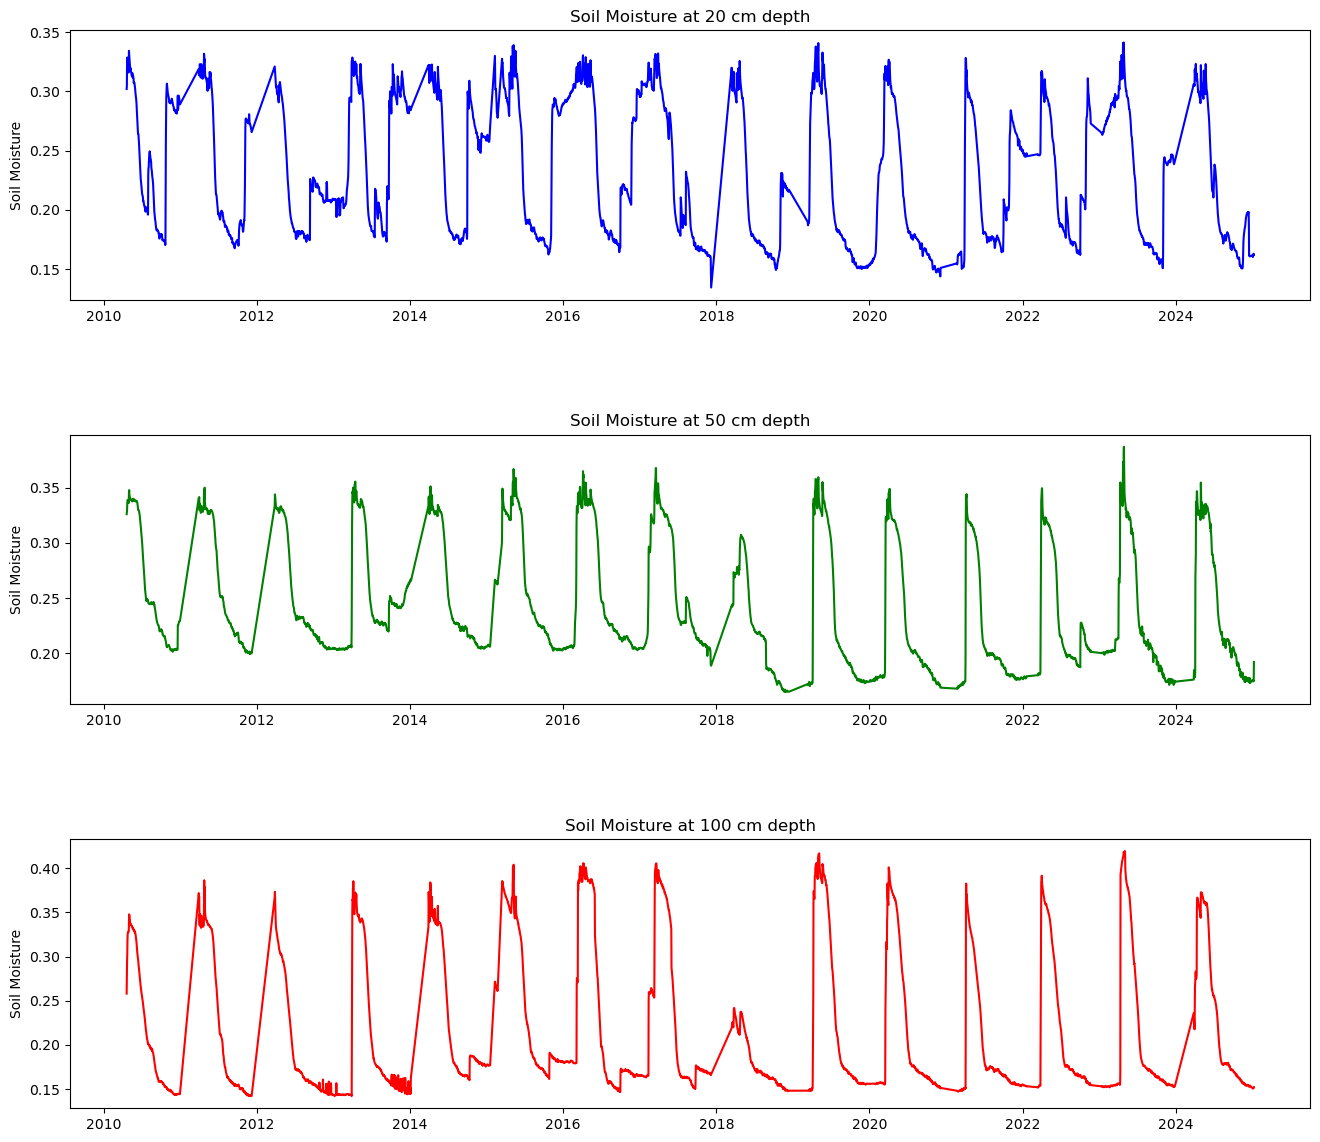

In [36]:
# Plot time series for soil moisture at different depths

# creating a 3x1 grid of subplots and create time series plots for soil moisture at different depths
fig, ax = plt.subplots(3, 1, figsize=(16, 14))

# adjusting the space between the subplots
plt.subplots_adjust(hspace=0.5)

ax[0].plot(soil_df['date'], soil_df['sm_20cm'], color='blue')
ax[0].set_title('Soil Moisture at 20 cm depth')
ax[0].set_ylabel('Soil Moisture')

ax[1].plot(soil_df['date'], soil_df['sm_50cm'], color='green')
ax[1].set_title('Soil Moisture at 50 cm depth')
ax[1].set_ylabel('Soil Moisture')

ax[2].plot(soil_df['date'], soil_df['sm_100cm'], color='red')
ax[2].set_title('Soil Moisture at 100 cm depth')
ax[2].set_ylabel('Soil Moisture')

plt.show()

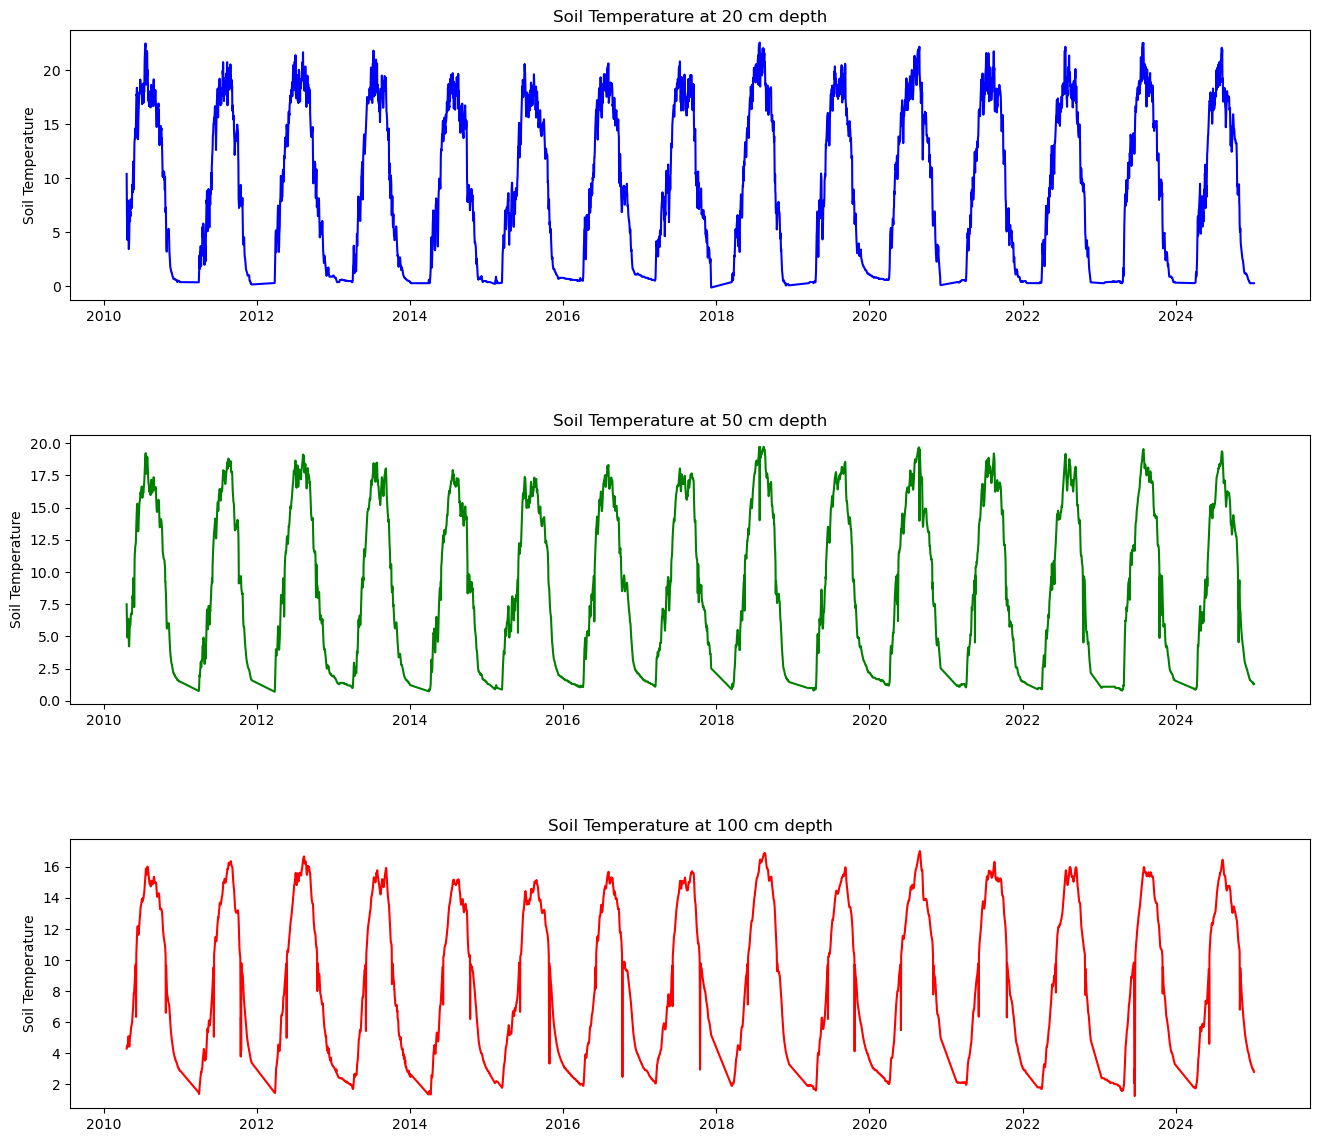

In [39]:
# Plot time series for soil temperature at different depths

# creating a 3x1 grid of subplots and create time series plots for soil moisture at different depths
fig, ax = plt.subplots(3, 1, figsize=(16, 14))

# adjusting the space between the subplots
plt.subplots_adjust(hspace=0.5)

ax[0].plot(soil_df['date'], soil_df['st_20cm'], color='blue')
ax[0].set_title('Soil Temperature at 20 cm depth')
ax[0].set_ylabel('Soil Temperature')

ax[1].plot(soil_df['date'], soil_df['st_50cm'], color='green')
ax[1].set_title('Soil Temperature at 50 cm depth')
ax[1].set_ylabel('Soil Temperature')

ax[2].plot(soil_df['date'], soil_df['st_100cm'], color='red')
ax[2].set_title('Soil Temperature at 100 cm depth')
ax[2].set_ylabel('Soil Temperature')

plt.show()

In [42]:
# Save soil data to parquet format 
soil_df.to_parquet('data/soil.parquet', index=False)

In [45]:
# Lincoln Creek Below Grizzly Reservoir NR Aspen, CO - 09073005
# USGS URL: https://dashboard.waterdata.usgs.gov/api/gwis/2.1/service/site?agencyCode=USGS&siteNumber=09073005&open=211313
site = '09073005' # site near Aspen, CO
display(nwis.get_record(sites=site, service='site'))

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,09073005,LINCOLN CREEK BELOW GRIZZLY RESERVOIR NR ASPEN...,ST,390448.85,1063659.7,39.080236,-106.616583,M,5,...,Y,NaN,NYNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# get instantaneous values (iv)
lincoln_creek_df = nwis.get_record(sites=site, service='dv', start='2009-01-01', end='2024-02-08').reset_index()

lincoln_creek_df = lincoln_creek_df[['datetime', '00060_Mean']]
lincoln_creek_df.columns = ['datetime', 'daily_discharge_cfs']
lincoln_creek_df['datetime'] = lincoln_creek_df['datetime'].dt.date # Extracting date from datetime

# Convert discharge from cubic feet per second to cubic centimeters per second
lincoln_creek_df['daily_discharge_cms'] = lincoln_creek_df['daily_discharge_cfs'] * 28316.8

# Drop the original cfs column 
lincoln_creek_df.drop(columns=['daily_discharge_cfs'], inplace=True)

# renameing datetime to date
lincoln_creek_df = lincoln_creek_df.rename(columns={'datetime': 'date'})

display(lincoln_creek_df.head())
print(lincoln_creek_df.isna().sum()) # check for NaN entries

,date,daily_discharge_cms
0,2009-04-01,94578.112
1,2009-04-02,77871.200
2,2009-04-03,79853.376
3,2009-04-04,76455.360
4,2009-04-05,77871.200


date                   0
daily_discharge_cms    0
dtype: int64


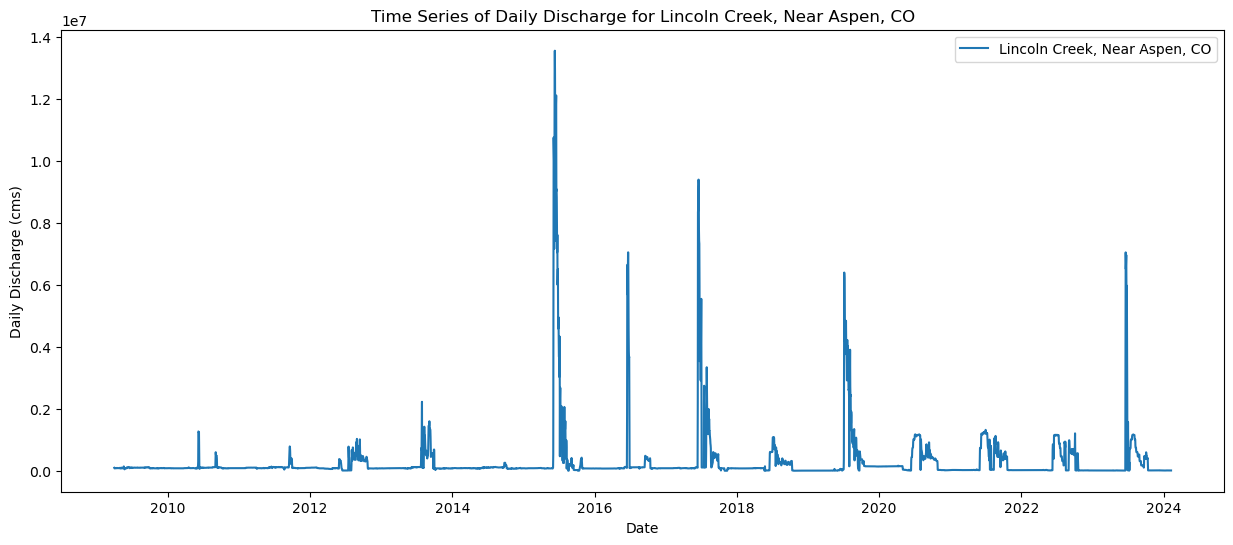

In [51]:
# Plot time series of daily discharge for Lincoln Creek Below Grizzly Reservoir NR Aspen, CO

plt.figure(figsize=(15, 6))
plt.plot(lincoln_creek_df['date'], lincoln_creek_df['daily_discharge_cms'], label='Lincoln Creek, Near Aspen, CO')
plt.xlabel('Date')
plt.ylabel('Daily Discharge (cms)')
plt.title('Time Series of Daily Discharge for Lincoln Creek, Near Aspen, CO')
plt.legend()
plt.show()

In [54]:
# Save stream data to parquet format 
lincoln_creek_df.to_parquet('data/water.parquet')

In [57]:
# Drought Well, Near Aspen, CO
# USGD URL: https://dashboard.waterdata.usgs.gov/api/gwis/2.1/service/site?agencyCode=USGS&siteNumber=395136108210004&open=212313

site = '395136108210004'
display(nwis.get_record(sites=site, service='site'))

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,local_time_fg,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no
0,USGS,395136108210004,SC00209824CBB4 TH75-13U,GW,395136.48,1082103.44,39.860133,-108.350956,Z,E,...,Y,C,Y Y,N300COPLTS,120TRTR,U,249.5,250,D,D9Y


In [60]:
# get instantaneous values (iv)
gwl_df = nwis.get_record(sites=site, service='dv', start='2009-01-01', end='2024-02-08').reset_index()

gwl_df = gwl_df[['datetime', '72019_Mean']]
gwl_df.columns = ['datetime', 'gwl']
gwl_df['datetime'] = gwl_df['datetime'].dt.date # Extracting date from datetime

# Convert ground water level from feet to centimeters
gwl_df['gwl'] = gwl_df['gwl'] * 30.48

# renameing datetime to date
gwl_df = gwl_df.rename(columns={'datetime': 'date'})

display(gwl_df.head())
print(gwl_df.isna().sum()) # check for NaN entries

,date,gwl
0,2010-06-22,1859.8896
1,2010-06-23,1861.7184
2,2010-06-24,1860.4992
3,2010-06-25,1859.2800
4,2010-06-26,1858.9752


date    0
gwl     0
dtype: int64


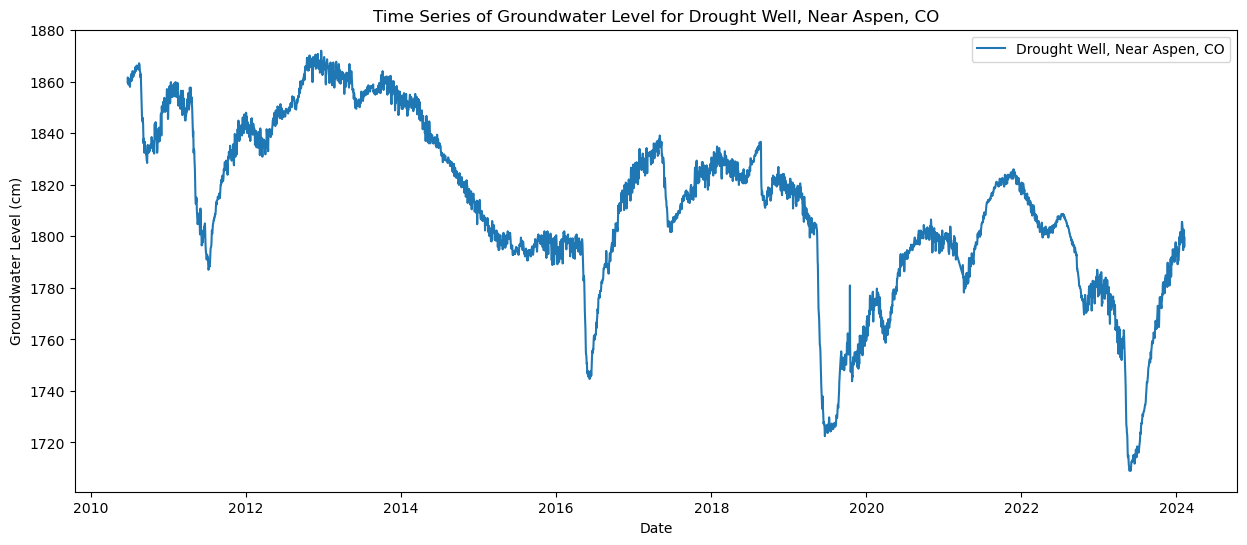

In [62]:
# Plot time series for Drought Well, Near Aspen, CO

plt.figure(figsize=(15, 6))
plt.plot(gwl_df['date'], gwl_df['gwl'], label='Drought Well, Near Aspen, CO')
plt.xlabel('Date')
plt.ylabel('Groundwater Level (cm)')
plt.title('Time Series of Groundwater Level for Drought Well, Near Aspen, CO')
plt.legend()
plt.show()

In [65]:
# Save ground water level data to parquet format 
gwl_df.to_parquet('data/gwl.parquet')

### Merging Predictor Data Sets

In [8]:
# reading air temperature and precipitation data
df_air_temp_precip = pd.read_parquet('data/weather.parquet')

# reading qwl data
df_gwl = pd.read_parquet('data/gwl.parquet')

# reading streamflow data
df_streamflow = pd.read_parquet('data/water.parquet')

# reading soil moisture and temperature data
df_soil = pd.read_parquet('data/soil.parquet')

# converting date object to datetime
df_air_temp_precip['date'] = pd.to_datetime(df_air_temp_precip['date'])
df_gwl['date'] = pd.to_datetime(df_gwl['date'])
df_streamflow['date'] = pd.to_datetime(df_streamflow['date'])
df_soil['date'] = pd.to_datetime(df_soil['date'])

In [10]:
# checking for min and max dates for each dataset

print('Air temperature and precipitation data')
print('Min date:', df_air_temp_precip.date.min())
print('Max date:', df_air_temp_precip.date.max())

print('GWL data')
print('Min date:', df_gwl.date.min())
print('Max date:', df_gwl.date.max())

print('Streamflow data')
print('Min date:', df_streamflow.date.min())
print('Max date:', df_streamflow.date.max())

print('Soil moisture and temperature data')
print('Min date:', df_soil.date.min())
print('Max date:', df_soil.date.max())

Air temperature and precipitation data
Min date: 1998-05-21 00:00:00
Max date: 2025-02-09 00:00:00
GWL data
Min date: 2010-06-22 00:00:00
Max date: 2024-02-08 00:00:00
Streamflow data
Min date: 2009-04-01 00:00:00
Max date: 2024-02-08 00:00:00
Soil moisture and temperature data
Min date: 2010-04-21 00:00:00
Max date: 2025-01-07 00:00:00


In [12]:
# merge datasets
df_aspen = df_air_temp_precip.merge(df_gwl, on='date', how='inner')
df_aspen = df_aspen.merge(df_soil, on='date', how='inner')
df_aspen = df_aspen.merge(df_streamflow, on='date', how='inner')

# filtering df to be from 2010
df_aspen = df_aspen[df_aspen['date'].dt.year >= 2010]

# dropping rows with missing values
df_aspen = df_aspen.dropna()

print(df_aspen.head())
print(df_aspen.tail())
print('Min date:', df_aspen.date.min())
print('Max date:', df_aspen.date.max())

        date  prcp  tmax  tmin        gwl   sm_20cm    st_20cm   sm_50cm  \
0 2010-06-22   0.0  23.9   5.0  1859.8896  0.243083  17.804167  0.325417   
1 2010-06-23   0.0  24.4   1.7  1861.7184  0.238542  17.829167  0.323625   
2 2010-06-24   0.0  26.7   6.1  1860.4992  0.236000  18.479167  0.322000   
3 2010-06-25   0.0  26.7   5.6  1859.2800  0.232583  19.112500  0.320125   
4 2010-06-26   0.5  22.8   6.1  1858.9752  0.229625  18.491667  0.317458   

     st_50cm  sm_100cm   st_100cm  daily_discharge_cms  
0  15.445833  0.278083  12.666667            94861.280  
1  15.529167  0.275625  12.820833            93445.440  
2  15.700000  0.272458  12.929167           100807.808  
3  16.029167  0.270875  13.083333           101940.480  
4  16.191667  0.268375  13.300000            93728.608  
           date  prcp  tmax  tmin        gwl   sm_20cm   st_20cm   sm_50cm  \
4193 2023-12-23   2.0   4.4  -4.9  1790.0904  0.238542  0.412500  0.172083   
4194 2023-12-24   0.8  -2.1 -16.6  1793.4432 

### Correlation Matrix

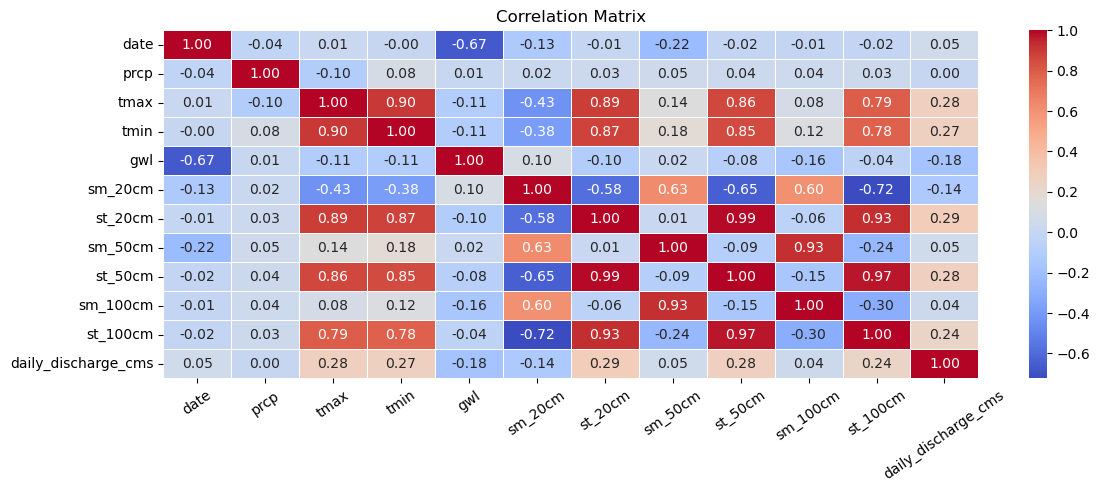

In [14]:
df = pd.DataFrame(df_aspen)

corr_matrix = df.corr()

plt.figure(figsize = (12, 5))
           
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.tick_params(axis = 'x', labelrotation = 35)

plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=1.0)
# Save the plot locally (optional)
#plt.savefig('data/Correlation_Matrix.jpg')
plt.show()

### Feature Legend 

- date: Date of Observations in Format year-month-day from 2010-06-22 to 2023-12-27
- prcp: Total Precipitation in Centimeters
- tmax: Maximum Temperature in Celsius
- tmin: Minimum Temperature in Celsius
- gwl: Level of the Water Table in Centimeters (measures how far the water is from the surface, larger measurements indicating there is less water in the well)
- sm_20cm: Soil Moisture Volumetric Water Content at 20 Centimeters depth
- st_20cm: Soil Temperature at 20 Centimeters depth
- sm_50cm: Soil Moisture Volumetric Water Content at 50 Centimeters depth
- st_50cm: Soil Temperature at 50 Centimeters depth
- sm_100cm: Soil Moisture Volumetric Water Content at 100 Centimeters depth
- st_100cm: Soil Temperature at 100 Centimeters depth
- daily_discharge_cms: Water Flow in Cubic Centimeters per Second

### Save the Cleaned Dataset of Predictors 

In [86]:
# Saving the merged dataframe as a parquet file
df_aspen.to_parquet('data/aspen.parquet')

### Drought Data - Target Variable

The target drought dataset contains five drought severity levels, None, D1 Moderate, D2 Severe, D3 Extreme, and D4 Exceptional. There is a sixth category, Abnormally Dry (D0), indicating areas that may be going into or are coming out of drought. Each of these categories had its own column. The D0 Abnormally Dry condition was excluded from the classification dataset since it was not a defined drought condition. This dataset was formatted for categorical classification by first using the idxmax function to determine the most severe drought level for each row. Then numerical values were assigned to the drought levels using the map function, creating a new column called drought_level_encoded, which can be used for classification. The original drought levels were dropped leaving the date and drought_level_encoded columns. This dataset was then merged by date with the cleaned df_aspen data frame containing the predictors, creating the df_class_aspen data frame.

In [128]:
# Data Download Link: https://www.drought.gov/states/colorado/county/pitkin
# Data Description: https://www.drought.gov/data-maps-tools/historical-drought-data-conditions-tool

df_target = pd.read_csv('data/USDM-pitkin-county-co.csv')

# delet unnecessary columns
df_target = df_target.drop(['State', 'County', 'MapDate', 'FIPS', 'StatisticFormatID'], axis=1)

# creating a new column date, for all dates between ValidStart and ValidEnd and replicating the row for each date

df_target['ValidStart'] = pd.to_datetime(df_target['ValidStart'])
df_target['ValidEnd'] = pd.to_datetime(df_target['ValidEnd'])

df_target['date'] = df_target.apply(lambda x: pd.date_range(start=x['ValidStart'], end=x['ValidEnd'], freq='D'), axis=1)
df_target = df_target.explode('date')
df_target = df_target.drop(['ValidStart', 'ValidEnd'], axis=1)

# Sorting the dataframe by date
df_target = df_target.sort_values(by='date')

# Dropping rows with duplicate dates
df_target = df_target.drop_duplicates(subset='date', keep='first')

# Resetting the index
df_target = df_target.reset_index(drop=True)

df_target.head


<bound method NDFrame.head of         None     D0     D1   D2   D3   D4       date
0     100.00   0.00   0.00  0.0  0.0  0.0 2000-01-04
1     100.00   0.00   0.00  0.0  0.0  0.0 2000-01-05
2     100.00   0.00   0.00  0.0  0.0  0.0 2000-01-06
3     100.00   0.00   0.00  0.0  0.0  0.0 2000-01-07
4     100.00   0.00   0.00  0.0  0.0  0.0 2000-01-08
...      ...    ...    ...  ...  ...  ...        ...
9172    9.62  90.38  17.26  0.0  0.0  0.0 2025-02-13
9173    9.62  90.38  17.26  0.0  0.0  0.0 2025-02-14
9174    9.62  90.38  17.26  0.0  0.0  0.0 2025-02-15
9175    9.62  90.38  17.26  0.0  0.0  0.0 2025-02-16
9176    9.62  90.38  17.26  0.0  0.0  0.0 2025-02-17

[9177 rows x 7 columns]>

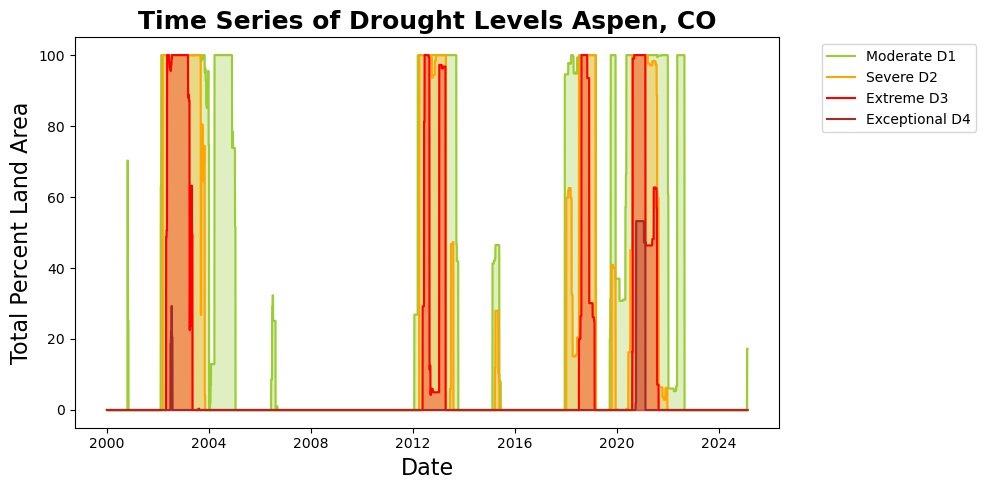

In [130]:
# Initialize plot
fig = plt.figure(figsize=(10,5))

# Moderate D1
plt.plot(df_target['date'], df_target['D1'], label='Moderate D1', color='yellowgreen')
plt.fill_between(df_target['date'], df_target['D1'], color='yellowgreen', alpha = 0.3)
# Severe D2
plt.plot(df_target['date'], df_target['D2'], label='Severe D2', color='orange')
plt.fill_between(df_target['date'], df_target['D2'], color='orange', alpha = 0.3)
# Extreme D3
plt.plot(df_target['date'], df_target['D3'], label='Extreme D3', color='red')
plt.fill_between(df_target['date'], df_target['D3'], color='red', alpha = 0.3)
# Exceptional D4
plt.plot(df_target['date'], df_target['D4'], label='Exceptional D4', color='brown')
plt.fill_between(df_target['date'], df_target['D4'], color='brown', alpha = 0.3)

plt.title('Time Series of Drought Levels Aspen, CO', fontsize=18, fontweight = 'bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Total Percent Land Area', fontsize=16)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()
# Save the plot locally (optional)
#plt.savefig('data/Drought_Levels.jpg')
plt.show()

In [132]:
#Create a DataFrame for Categorical Classification
df_class_target = df_target.copy()

# Define drought severity order: D4 > D3 > D2 > D1 > None (Remove D0)
drought_levels = ['D4', 'D3', 'D2', 'D1', 'None']

df_class_target['drought_level'] = df_class_target[drought_levels].idxmax(axis=1)

# Define encoding: No drought = 0 rest are ranked by severity
drought_score = {
    'None': 0,  # No drought
    'D1': 1,    # Moderate Drought
    'D2': 2,    # Severe Drought
    'D3': 3,    # Extreme Drought
    'D4': 4     # Exceptional Drought
}

# Encode drought_level column into numeric labels for classification
df_class_target['drought_level_encoded'] = df_class_target['drought_level'].map(drought_score)

# Drop unnecessary columns
df_class_target = df_class_target.drop(columns=['None', 'D0', 'D1', 'D2', 'D3', 'D4', 'drought_level'])
                                                                
df_class_target.head()

,date,drought_level_encoded
0,2000-01-04,0
1,2000-01-05,0
2,2000-01-06,0
3,2000-01-07,0
4,2000-01-08,0


In [ ]:
# Saving the target dataframe as a parquet file
df_class_target.to_parquet('data/class_target.parquet')


In [21]:
df_target = pd.read_parquet('data/class_target.parquet')
print(df_target.head())
print(df_target.isna().sum()) # check for missing values

        date  drought_level_encoded
0 2000-01-04                      0
1 2000-01-05                      0
2 2000-01-06                      0
3 2000-01-07                      0
4 2000-01-08                      0
date                     0
drought_level_encoded    0
dtype: int64


### Merge Predictor Dataset with Drought Labels

In [ ]:
df_aspen = pd.read_parquet('data/aspen.parquet')
df_class_aspen = df_aspen.merge(df_class_target, on='date', how='inner')
print(df_class_aspen.head())
print(np.unique(df_class_aspen['drought_level_encoded']))
print(df_class_aspen.isna().sum())
# Saving the merged dataframe as a parquet file
df_class_aspen.to_parquet('data/class_aspen.parquet')


/var/folders/kp/jh581jd92_13tmgptdfkfx480000gn/T/ipykernel_3644/954399107.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)


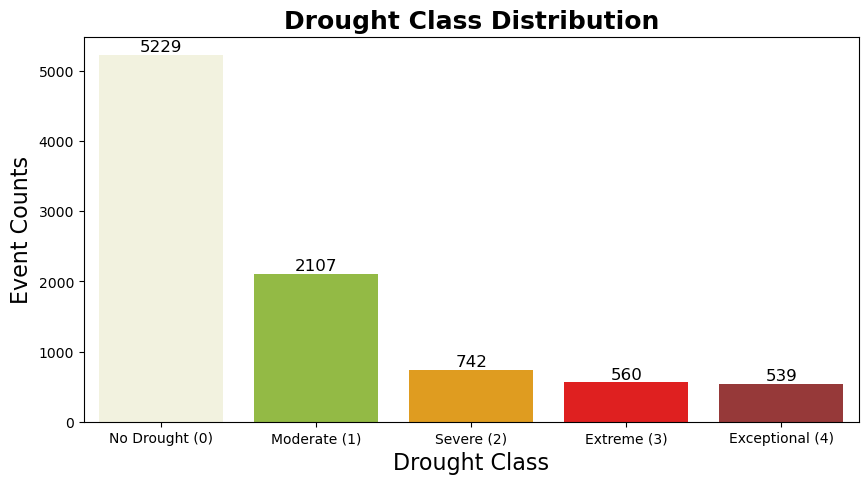

In [140]:
# Initialize plot
plt.figure(figsize=(10, 5))

# Counts of each drought class
class_counts = df_class_target['drought_level_encoded'].value_counts().sort_index()

# Define class labels 
class_labels = ['No Drought (0)', 'Moderate (1)', 'Severe (2)', 'Extreme (3)', 'Exceptional (4)']

# Define colors
colors = ['beige', 'yellowgreen', 'orange', 'red', 'brown']

# Plot the distribution
sns.barplot(x=class_counts.index, y=class_counts.values, palette=colors)
plt.xticks(ticks=class_counts.index, labels=class_labels)
plt.xlabel("Drought Class", fontsize=16)
plt.ylabel("Event Counts", fontsize=16)
plt.title("Drought Class Distribution", fontsize=18, fontweight = 'bold')

# Show values on bars
for i, value in enumerate(class_counts.values):
    plt.text(i, value + 50, str(value), ha='center', fontsize=12)
    
# Save the plot locally (optional)
#plt.savefig('data/Drought_Bar.jpg')
plt.show()

### Data References

Weather data, precipitation, max temperature and min temperature, Aspen Pitkin Co Airport Sardy Field, CO US:
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00093073/detail

Daily discharge data for Lincoln Creek, Near Aspen, CO:
https://dashboard.waterdata.usgs.gov/api/gwis/2.1/service/site?agencyCode=USGS&siteNumber=09073005&open=211313

Ground water level data, drought well near Aspen, CO:
https://dashboard.waterdata.usgs.gov/api/gwis/2.1/service/site?agencyCode=USGS&siteNumber=395136108210004&open=212313

Soil moisture and temperature data Montrose, CO: 
https://www.ncei.noaa.gov/data/us-climate-reference-network/access/derived-products/soil/soilanom/

Drought data, Pitkin County, CO:
https://www.drought.gov/states/colorado/county/pitkin